# Import necessary libraries

In [1]:
import pandas as pd 
import random
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Visualize and understand the data

In [2]:
data_path = Path("/kaggle/input/potato-diseases-datasets")

In [3]:
classes = os.listdir(data_path)
class_images = {}
for class_name in classes:
    class_images[class_name] = random.sample(os.listdir(os.path.join(data_path, class_name)), 5)

In [4]:
class_images


{'Black Scurf': ['34.jpg', '37.jpg', '11.jpg', '24.jpg', '40.jpg'],
 'Blackleg': ['23.jpg', '35.jpeg', '19.jpg', '56.jpg', '3.jpg'],
 'Common Scab': ['58.jpg', '29.jpg', '43.jpg', '30.jpg', '60.jpg'],
 'Pink Rot': ['37.jpg', '17.jpg', '24.jpg', '15.jpg', '6.jpg'],
 'Dry Rot': ['53.jpg', '50.jpg', '11.jpg', '42.jpg', '15.jpg'],
 'Miscellaneous': ['69.jpg', '61.jpg', '35.jpg', '5.jpg', '22.jpg'],
 'Healthy Potatoes': ['61.jpg', '50.jpg', '44.jpg', '13.jpg', '60.jpg']}

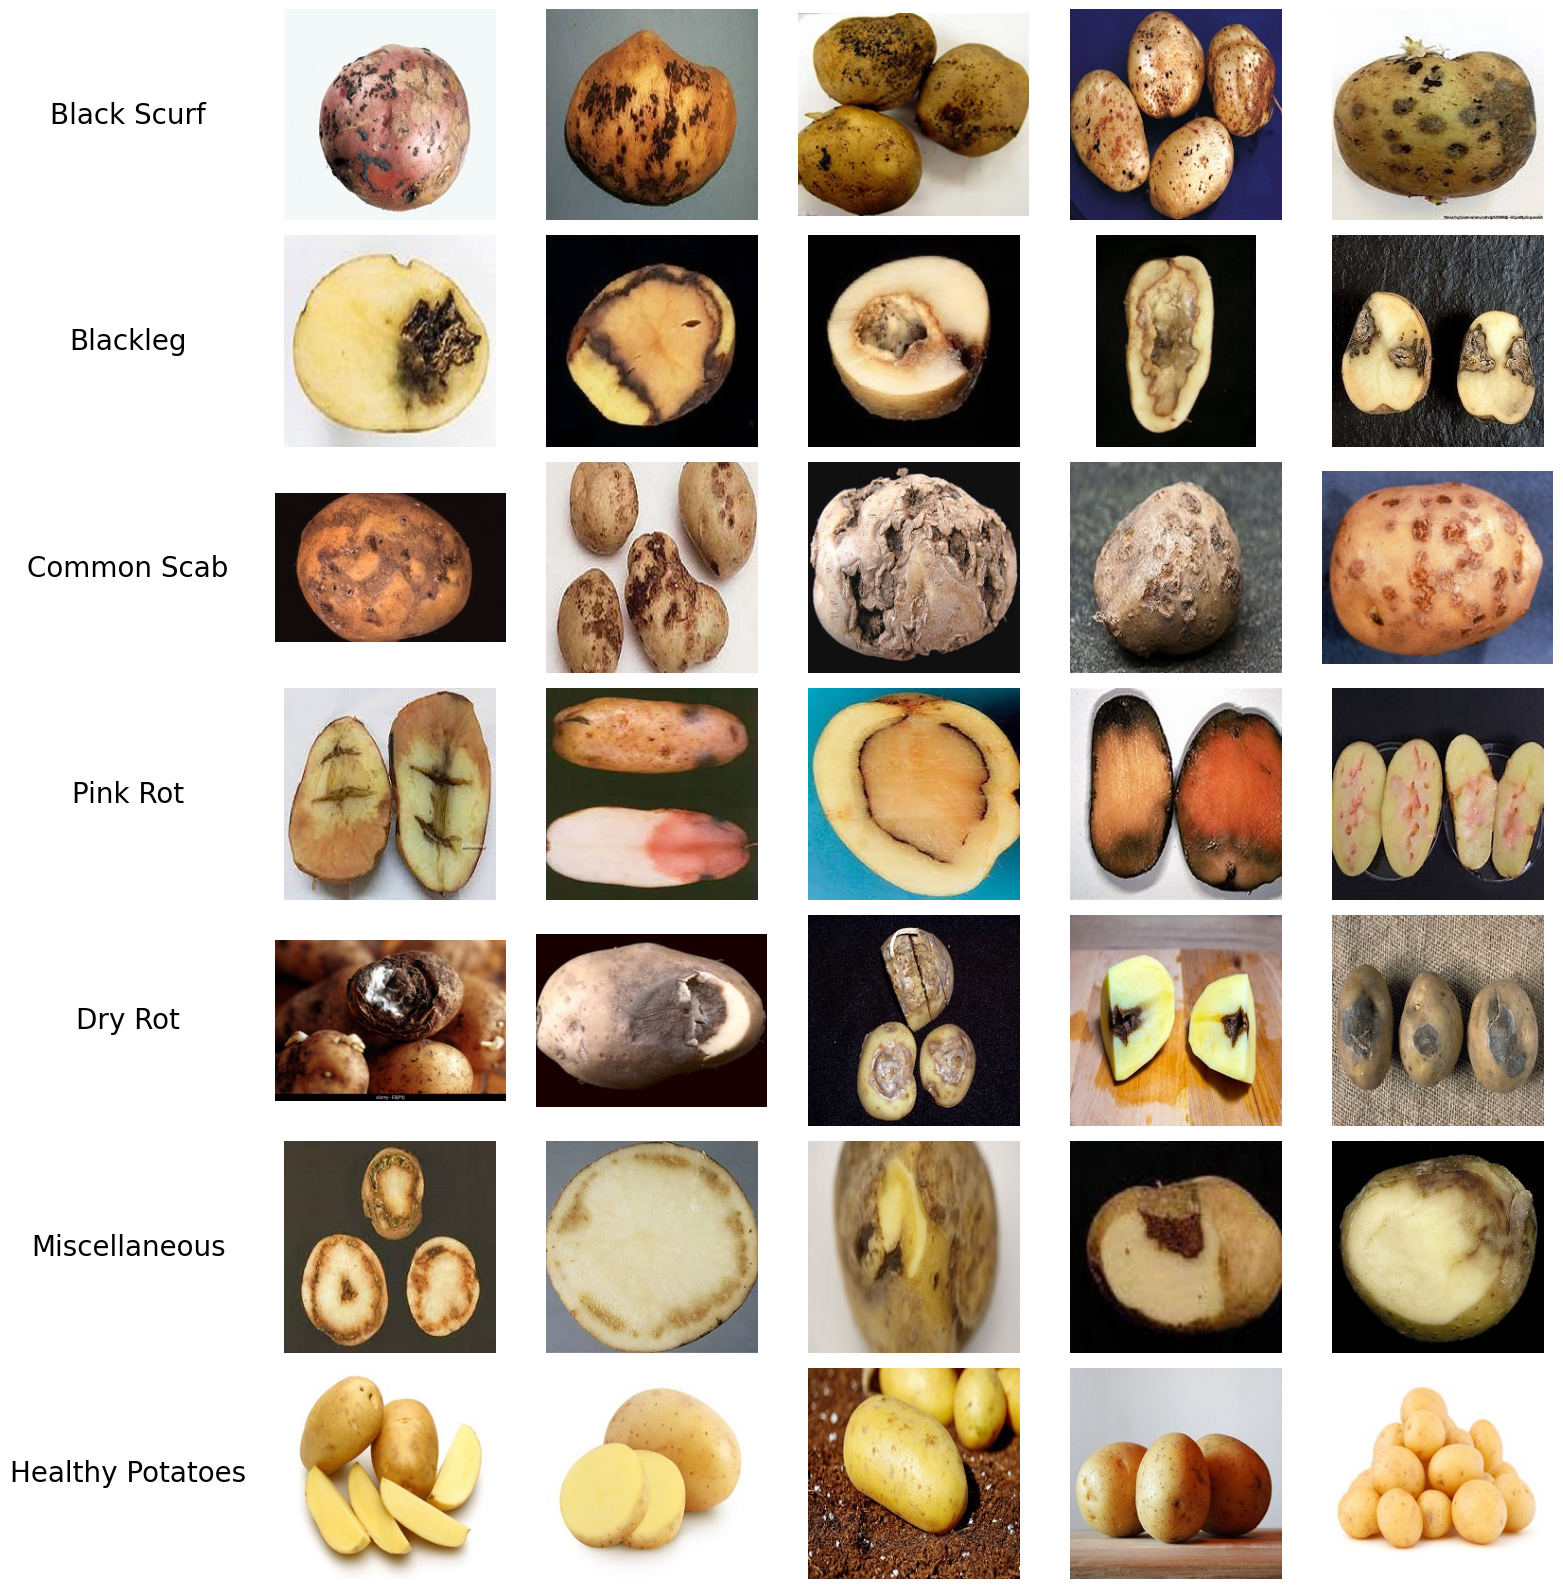

In [5]:
fig, ax = plt.subplots(7, 6, figsize=(16, 16))

for i, class_name in enumerate(class_images):
    # Display the class name before each row
    ax[i, 0].text(0.5, 0.5, class_name, fontsize=20, ha="center", va="center", transform=ax[i, 0].transAxes)
    ax[i, 0].axis(False)
    
    for j, img_file in enumerate(class_images[class_name]):
        image = cv2.imread(os.path.join(data_path, class_name, img_file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax[i, j+1].imshow(image)
        ax[i, j+1].axis(False)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [6]:
# Check number of images in each class 
for i in os.listdir(data_path):
    length = len(os.listdir(data_path / i))
    
    print(f"{i}: {length} images")

Black Scurf: 58 images
Blackleg: 60 images
Common Scab: 62 images
Pink Rot: 57 images
Dry Rot: 60 images
Miscellaneous: 74 images
Healthy Potatoes: 80 images


In [7]:
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
data_path = Path("/kaggle/input/potato-diseases-datasets")

image_datasets = datasets.ImageFolder(root=data_path, 
                                      transform=data_transforms)

In [9]:
torch.manual_seed(42)
train_size = int(0.8 * len(image_datasets))
test_size = len(image_datasets) - train_size

train_datasets, test_datasets = torch.utils.data.random_split(dataset=image_datasets, lengths=[train_size, test_size])

In [10]:
next(iter(train_datasets))

(tensor([[[-0.0629, -0.0629, -0.0801,  ..., -0.2513, -0.2342, -0.2171],
          [-0.0801, -0.0629, -0.0629,  ..., -0.2342, -0.2171, -0.1999],
          [-0.0801, -0.0629, -0.0458,  ..., -0.1999, -0.1828, -0.1828],
          ...,
          [-0.5253, -0.5253, -0.5082,  ..., -1.1075, -1.0904, -1.0733],
          [-0.5253, -0.5253, -0.5253,  ..., -1.1075, -1.0904, -1.0904],
          [-0.5082, -0.5082, -0.5253,  ..., -1.1418, -1.1247, -1.1247]],
 
         [[ 1.0980,  1.0980,  1.1155,  ...,  0.9405,  0.9580,  0.9755],
          [ 1.0805,  1.0805,  1.0980,  ...,  0.9580,  0.9755,  0.9930],
          [ 1.0805,  1.0805,  1.0980,  ...,  0.9930,  1.0105,  1.0105],
          ...,
          [ 0.4853,  0.5028,  0.5203,  ..., -0.3550, -0.3375, -0.3200],
          [ 0.4853,  0.4853,  0.5028,  ..., -0.3901, -0.3725, -0.3725],
          [ 0.4853,  0.4853,  0.5028,  ..., -0.4251, -0.4076, -0.4076]],
 
         [[ 2.0823,  2.0823,  2.0997,  ...,  1.9428,  1.9603,  1.9777],
          [ 2.0474,  2.0474,

In [11]:
class_names = image_datasets.classes

In [12]:
torch.manual_seed(42)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_datasets,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_datasets,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

# Create function to create dataloader

In [13]:
def create_dataloader(data_path, transform, batch_size: int, num_workers: int):
    
    image_datasets = datasets.ImageFolder(root=data_path, transform=transform)
    
    class_names = image_datasets.classes
    
    train_size = int(0.8 * len(image_datasets))
    test_size = len(image_datasets) - train_size
    
    train_datasets, test_datasets = torch.utils.data.random_split(dataset=image_datasets, 
                                                                  lengths=[train_size, test_size])
    
    train_dataloader = DataLoader(dataset=train_datasets,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers)

    test_dataloader = DataLoader(dataset=test_datasets,
                                 batch_size=batch_size,
                                 shuffle=False,
                                 num_workers=num_workers)
    
    return train_dataloader, test_dataloader, class_names

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Create train and test loop functions

In [15]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Put data to target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)
        
        # 2. Calculate and accumulate loss 
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss Backward
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
        # Calculate and accumulate accuracy 
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
        
    # Adjust metrics to get average loss and accuracy per batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc


In [16]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    
    # Put model in eval mode
    model.eval()
    
    # Setup test_loss and test_acc values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through dataloader batches
        for batch, (X, y) in enumerate(dataloader): 
            # Send data to target device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred_logits = model(X)
            
            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)
            
        # Adjust metric to get average loss, accuracy per batch
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        return test_loss, test_acc

In [17]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(),
          epochs: int=5):
    
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
              }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [18]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set numper of epochs, batch size and num_workers
NUM_EPOCHS = 100
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Resnet model
weights = torchvision.models.ResNet50_Weights.DEFAULT
resnet = torchvision.models.resnet50(weights=weights).to(device)

# Resnet transform
res_transforms = weights.transforms()

# Create dataset and dataloader
train_dataloader, test_dataloader, class_names = create_dataloader(data_path,
                                                                   transform=res_transforms,
                                                                   batch_size=BATCH_SIZE,
                                                                   num_workers=NUM_WORKERS)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
resnet_results = train(model=resnet, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 248MB/s]


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8106 | train_acc: 0.4089 | test_loss: 1.2072 | test_acc: 0.6551
Epoch: 2 | train_loss: 0.6541 | train_acc: 0.7682 | test_loss: 1.5157 | test_acc: 0.5602
Epoch: 3 | train_loss: 0.3392 | train_acc: 0.8958 | test_loss: 1.8837 | test_acc: 0.5602
Epoch: 4 | train_loss: 0.1808 | train_acc: 0.9401 | test_loss: 1.3933 | test_acc: 0.6890
Epoch: 5 | train_loss: 0.1861 | train_acc: 0.9427 | test_loss: 1.2898 | test_acc: 0.6825
Epoch: 6 | train_loss: 0.1863 | train_acc: 0.9479 | test_loss: 1.2243 | test_acc: 0.6312
Epoch: 7 | train_loss: 0.1576 | train_acc: 0.9583 | test_loss: 1.0564 | test_acc: 0.7431
Epoch: 8 | train_loss: 0.1755 | train_acc: 0.9505 | test_loss: 1.0304 | test_acc: 0.7431
Epoch: 9 | train_loss: 0.2858 | train_acc: 0.9036 | test_loss: 1.1710 | test_acc: 0.6663
Epoch: 10 | train_loss: 0.3977 | train_acc: 0.9193 | test_loss: 2.4081 | test_acc: 0.4190
Epoch: 11 | train_loss: 0.3871 | train_acc: 0.8854 | test_loss: 3.3425 | test_acc: 0.4464
Epoch: 12 | train_l

In [19]:
from typing import List, Dict, Tuple

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

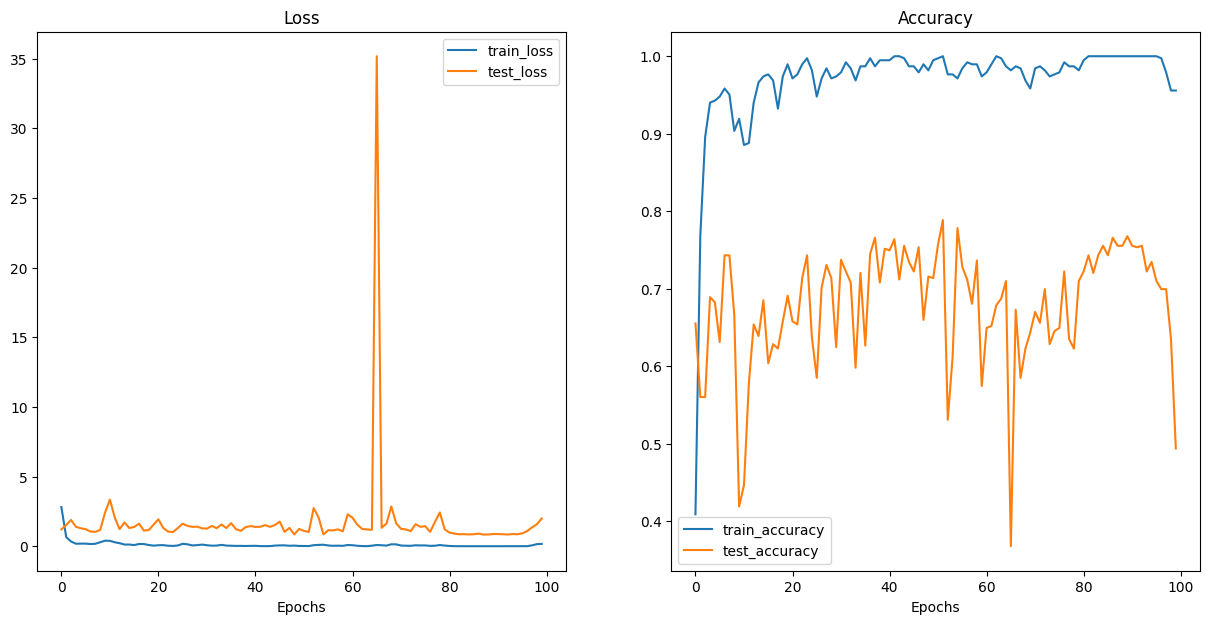

In [20]:
# plot the loss curves of resnet model
plot_loss_curves(resnet_results)

In [21]:
# Save the trained model
def save_model(model, filepath="potato_disease_resnet.pth"):
    """
    Save the trained model to a file.
    
    Args:
        model: The trained model to save
        filepath: Path where to save the model
    """
    # Save the model state dictionary
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_names': class_names,
        'model_architecture': 'resnet50'
    }, filepath)
    print(f"Model saved to {filepath}")

# Usage: Save the trained ResNet model
save_model(resnet, "potato_disease_resnet.pth")

Model saved to potato_disease_resnet.pth


In [22]:
# Load the saved model
def load_model(filepath="potato_disease_resnet.pth", device=device):
    """
    Load a saved model from a file.
    
    Args:
        filepath: Path to the saved model file
        device: Device to load the model to (cuda or cpu)
        
    Returns:
        Loaded model and class names
    """
    # Load the checkpoint
    checkpoint = torch.load(filepath, map_location=device)
    
    # Create a new model with the same architecture
    weights = torchvision.models.ResNet50_Weights.DEFAULT
    model = torchvision.models.resnet50(weights=None).to(device)
    
    # Load the saved state dictionary
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Get class names from checkpoint
    class_names = checkpoint['class_names']
    
    # Set model to evaluation mode
    model.eval()
    
    print(f"Model loaded from {filepath}")
    print(f"Classes: {class_names}")
    
    return model, class_names

# Usage: Load the saved model
# loaded_model, loaded_class_names = load_model("potato_disease_resnet.pth")

Model loaded from potato_disease_resnet.pth
Classes: ['Black Scurf', 'Blackleg', 'Common Scab', 'Dry Rot', 'Healthy Potatoes', 'Miscellaneous', 'Pink Rot']


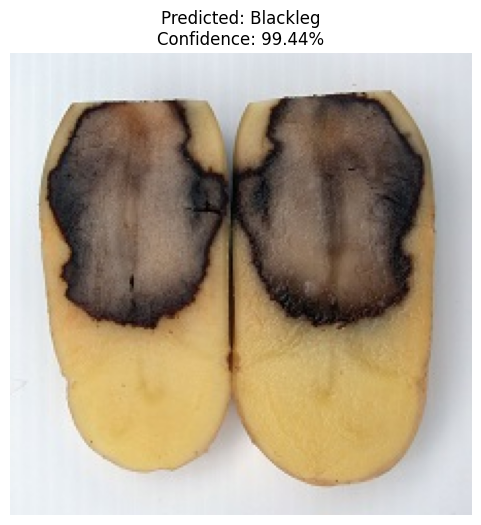

Predicted: Blackleg with 99.44% confidence


In [24]:
# Predict on a single image
def predict_image(model, image_path, class_names, device=device):
    """
    Predict the class of a single image.
    
    Args:
        model: Loaded model
        image_path: Path to the image file
        class_names: List of class names
        device: Device to run inference on
        
    Returns:
        Predicted class and confidence score
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    
    # Use the same transforms as during training
    weights = torchvision.models.ResNet50_Weights.DEFAULT
    transform = weights.transforms()
    
    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)
    
    # Get class name and confidence
    predicted_class = class_names[predicted_idx.item()]
    confidence_score = confidence.item()
    
    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence_score:.2%}")
    plt.axis('off')
    plt.show()
    
    return predicted_class, confidence_score

# Usage example:
loaded_model, class_names = load_model("potato_disease_resnet.pth")
prediction, confidence = predict_image(loaded_model, "/kaggle/input/potato-diseases-datasets/Blackleg/1.jpg", class_names)
print(f"Predicted: {prediction} with {confidence:.2%} confidence")

In [27]:
# Snippet 1: Convert PyTorch model to ONNX format
def convert_model_to_onnx(model, class_names, output_path="potato_disease_resnet.onnx"):
    """
    Convert a trained PyTorch model to ONNX format for lightweight deployment.
    
    Args:
        model: Trained PyTorch model
        class_names: List of class names
        output_path: Path to save ONNX model
    """
    import json
    import torch
    
    # Set model to evaluation mode
    model.eval()
    
    # Create dummy input with correct shape (batch_size, channels, height, width)
    batch_size = 1
    dummy_input = torch.randn(batch_size, 3, 224, 224).to(device)
    
    # Export to ONNX
    torch.onnx.export(
        model,                    # Model being exported
        dummy_input,              # Model input (or a tuple for multiple inputs)
        output_path,              # Where to save the model
        export_params=True,       # Store trained parameter weights
        opset_version=11,         # ONNX opset version
        do_constant_folding=True, # Optimize constant folding
        input_names=['input'],    # Input layer name
        output_names=['output'],  # Output layer name
        dynamic_axes={            # Dynamic axes for variable batch size
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    
    # Save class names to JSON file
    class_names_path = output_path.replace('.onnx', '_classes.json')
    with open(class_names_path, 'w') as f:
        json.dump(class_names, f)
    
    # Save preprocessing info
    transform_info = {
        'input_size': 224,
        'mean': [0.485, 0.456, 0.406],
        'std': [0.229, 0.224, 0.225]
    }
    transform_path = output_path.replace('.onnx', '_transform.json')
    with open(transform_path, 'w') as f:
        json.dump(transform_info, f)
    
    print(f"✓ ONNX model saved: {output_path}")
    print(f"✓ Class names saved: {class_names_path}")
    print(f"✓ Transform info saved: {transform_path}")
    print(f"✓ Model can now be used WITHOUT PyTorch!")

# Usage in your notebook (after training):
convert_model_to_onnx(resnet, class_names, "potato_disease_resnet.onnx")

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

✓ ONNX model saved: potato_disease_resnet.onnx
✓ Class names saved: potato_disease_resnet_classes.json
✓ Transform info saved: potato_disease_resnet_transform.json
✓ Model can now be used WITHOUT PyTorch!


In [49]:
# Snippet 2: Load ONNX model (FIXED VERSION)
"""
Save this as 'load_onnx_model.py'
Requirements: pip install onnxruntime Pillow numpy
"""

import onnxruntime as ort
import numpy as np
import json
from PIL import Image

class ONNXPotatoDiseaseModel:
    def __init__(self, model_path="/kaggle/working/potato_disease_resnet.onnx"):
        """
        Load ONNX model for potato disease classification.
        
        Args:
            model_path: Path to .onnx model file
        """
        # Load ONNX model with optimized providers
        self.session = ort.InferenceSession(
            model_path,
            providers=['CPUExecutionProvider']  # Use CPU only
        )
        
        # Get input name from model
        self.input_name = self.session.get_inputs()[0].name
        
        # Load class names
        class_names_path = model_path.replace('.onnx', '_classes.json')
        with open(class_names_path, 'r') as f:
            self.class_names = json.load(f)
        
        # Load transform info
        transform_path = model_path.replace('.onnx', '_transform.json')
        with open(transform_path, 'r') as f:
            self.transform_info = json.load(f)
        
        print(f"✓ Model loaded: {model_path}")
        print(f"✓ Input name: {self.input_name}")
        print(f"✓ Classes: {self.class_names}")
        print(f"✓ Input size: {self.transform_info['input_size']}")
    
    def preprocess_image(self, image_path):
        """
        Preprocess image for model input with proper float32 conversion.
        """
        # Load image
        image = Image.open(image_path).convert('RGB')
        
        # Resize and crop - simpler method
        from PIL import Image as PILImage
        target_size = self.transform_info['input_size']
        
        # Resize maintaining aspect ratio
        image = image.resize((target_size, target_size))
        
        # Convert to numpy array and normalize
        image_array = np.array(image).astype(np.float32) / 255.0
        
        # Normalize with mean and std
        mean = np.array(self.transform_info['mean'], dtype=np.float32).reshape(1, 1, 3)
        std = np.array(self.transform_info['std'], dtype=np.float32).reshape(1, 1, 3)
        
        # Normalize (image is in HWC format)
        image_array = (image_array - mean) / std
        
        # Change from HWC to CHW format (PyTorch format)
        image_array = np.transpose(image_array, (2, 0, 1))
        
        # Add batch dimension
        image_array = np.expand_dims(image_array, axis=0)
        
        # Ensure it's float32
        image_array = image_array.astype(np.float32)
        
        return image_array, image

In [50]:
# from load_onnx_model import ONNXPotatoDiseaseModel

model = ONNXPotatoDiseaseModel(
    model_path="/kaggle/working/potato_disease_resnet.onnx"
)


✓ Model loaded: /kaggle/working/potato_disease_resnet.onnx
✓ Input name: input
✓ Classes: ['Black Scurf', 'Blackleg', 'Common Scab', 'Dry Rot', 'Healthy Potatoes', 'Miscellaneous', 'Pink Rot']
✓ Input size: 224


In [47]:
# Snippet 3: Make predictions with ONNX model (FIXED VERSION)

def predict_image_onnx(model, image_path, top_k=3):
    """
    Make prediction on a single image.
    
    Args:
        model: ONNXPotatoDiseaseModel instance
        image_path: Path to image file
        top_k: Return top k predictions
    
    Returns:
        Dictionary with predictions
    """
    # Preprocess image
    input_array, original_image = model.preprocess_image(image_path)
    
    # Debug: Check data type and shape
    print(f"Input shape: {input_array.shape}")
    print(f"Input dtype: {input_array.dtype}")
    print(f"Input range: [{input_array.min():.3f}, {input_array.max():.3f}]")
    
    # Run inference - FIXED: use correct input name and ensure float32
    outputs = model.session.run(None, {model.input_name: input_array})
    logits = outputs[0][0]  # Remove batch dimension
    
    print(f"Logits shape: {logits.shape}")
    
    # Convert to probabilities using softmax (numerically stable)
    max_logits = np.max(logits)
    exp_logits = np.exp(logits - max_logits)
    probabilities = exp_logits / np.sum(exp_logits)
    
    # Get top k predictions
    top_indices = np.argsort(probabilities)[-top_k:][::-1]
    
    # Prepare results
    predictions = []
    for idx in top_indices:
        predictions.append({
            'class': model.class_names[idx],
            'confidence': float(probabilities[idx]),
            'percentage': f"{probabilities[idx] * 100:.2f}%"
        })
    
    return {
        'image_path': image_path,
        'top_prediction': predictions[0],
        'all_predictions': predictions,
        'is_healthy': predictions[0]['class'] == 'Potato___healthy' if 'Potato___healthy' in model.class_names else None
    }

def predict_and_display(model, image_path):
    """
    Make prediction and display results.
    
    Args:
        model: ONNXPotatoDiseaseModel instance
        image_path: Path to image file
    """
    import matplotlib.pyplot as plt
    
    # Get prediction
    result = predict_image_onnx(model, image_path)
    
    # Display image
    image = Image.open(image_path)
    
    plt.figure(figsize=(10, 8))
    
    # Show image
    plt.subplot(2, 1, 1)
    plt.imshow(image)
    plt.title(f"Prediction: {result['top_prediction']['class']}")
    plt.axis('off')
    
    # Show confidence bars
    plt.subplot(2, 1, 2)
    classes = [p['class'].replace('Potato___', '') for p in result['all_predictions']]
    confidences = [p['confidence'] * 100 for p in result['all_predictions']]
    
    bars = plt.barh(classes, confidences, color='skyblue')
    plt.xlabel('Confidence (%)')
    plt.title('Top Predictions')
    plt.xlim([0, 100])
    
    # Add percentage labels
    for bar, conf in zip(bars, confidences):
        plt.text(bar.get_width() - 1, bar.get_y() + bar.get_height()/2,
                f'{conf:.1f}%', va='center', ha='right', color='white', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return result

def predict_batch(model, image_paths):
    """
    Predict on multiple images at once.
    
    Args:
        model: ONNXPotatoDiseaseModel instance
        image_paths: List of image paths
    
    Returns:
        List of prediction results
    """
    results = []
    for img_path in image_paths:
        try:
            result = predict_image_onnx(model, img_path, top_k=1)
            results.append(result)
            print(f"{img_path}: {result['top_prediction']['class']} ({result['top_prediction']['percentage']})")
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            results.append({'image_path': img_path, 'error': str(e)})
    
    return results

Input shape: (1, 3, 224, 224)
Input dtype: float32
Input range: [-2.118, 2.640]
Logits shape: (1000,)


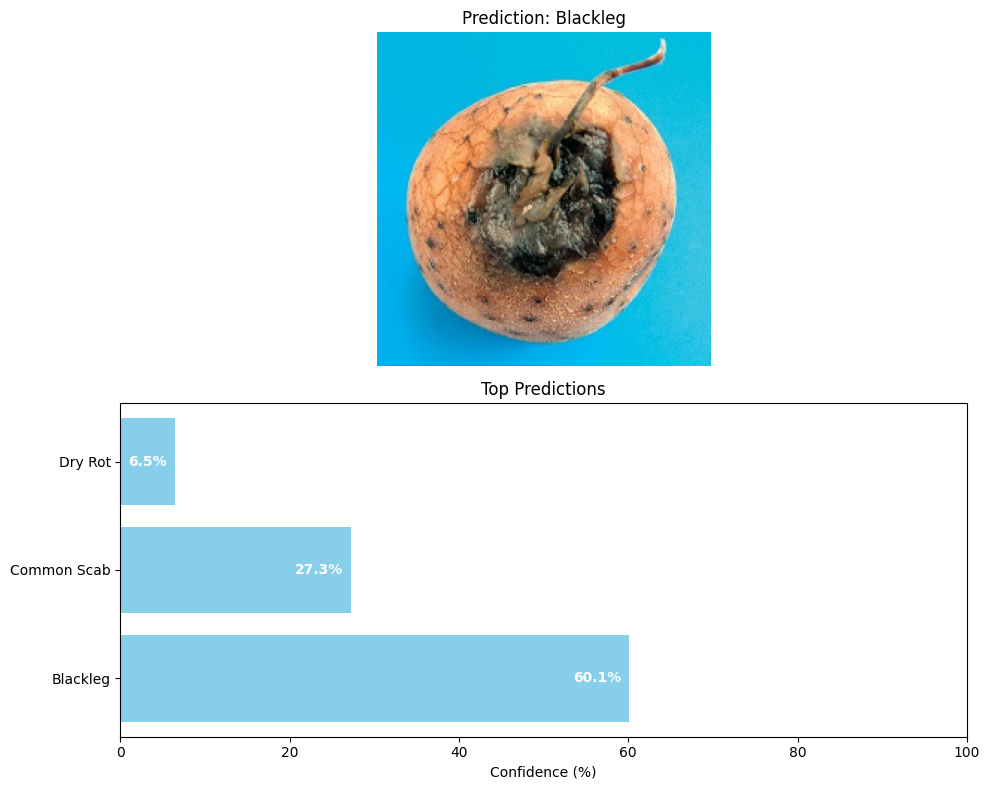

{'image_path': '/kaggle/input/potato-diseases-datasets/Blackleg/10.jpg', 'top_prediction': {'class': 'Blackleg', 'confidence': 0.6012965440750122, 'percentage': '60.13%'}, 'all_predictions': [{'class': 'Blackleg', 'confidence': 0.6012965440750122, 'percentage': '60.13%'}, {'class': 'Common Scab', 'confidence': 0.2727369964122772, 'percentage': '27.27%'}, {'class': 'Dry Rot', 'confidence': 0.06451010704040527, 'percentage': '6.45%'}], 'is_healthy': None}


In [51]:
result = predict_and_display(
    model,
    "/kaggle/input/potato-diseases-datasets/Blackleg/10.jpg"
)

print(result)


In [32]:
!pip install --no-cache-dir --upgrade onnxruntime


  Obtaining dependency information for onnxruntime from https://files.pythonhosted.org/packages/fb/56/179bf90679984c85b417664c26aae4f427cba7514bd2d65c43b181b7b08b/onnxruntime-1.23.2-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for coloredlogs from https://files.pythonhosted.org/packages/a7/06/3d6badcf13db419e25b07041d9c7b4a2c331d3f4e7134445ec5df57714cd/coloredlogs-15.0.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for humanfriendly>=9.1 from https://files.pythonhosted.org/packages/f0/0f/310fb31e39e2d734ccaa2c0fb981ee41f7bd5056ce9bc29b2248bd569169/humanfriendly-10.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 216.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 199.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 325.9 MB/s eta 0:00:00


In [38]:
import onnxruntime as ort
